# Analysis of recall and recognition results

In particular, we aim to analyse how well three different models predict the memory results.

In [1]:
%matplotlib inline

In [2]:
from __future__ import division

In [3]:
import pandas
import numpy
import cPickle as pickle
from utils import datautils

import configobj

import seaborn as sns

from utils import topicmodels
from utils import utils

import warnings
warnings.filterwarnings('ignore') # Some warnings are just annoying

## Load up vocab

In [4]:
vocabulary = open('_cache/bnc_vocab_49328.txt').read().split()
vocab = datautils.Vocab(vocabulary)

## Load up recall data

In [5]:
Df = {}
Df['recall'] = pandas.read_pickle('_cache/brisbane_06b643a_recall_results.pkl')

Filter data frame by only responses where the recalled word is in the vocabulary.

In [6]:
I = map(lambda word: True if word in vocabulary else False, Df['recall']['word'])
Df['recall'] = Df['recall'][I]

In [7]:
Df['recall'].head()

,session,subject,slide,text,word
0,186a069,4ba33f7,cc3a8e4,11,apparently
5,186a069,4ba33f7,cc3a8e4,11,law
9,186a069,4ba33f7,cc3a8e4,11,directive
11,186a069,4ba33f7,cc3a8e4,11,faith
12,186a069,4ba33f7,cc3a8e4,11,family


Confirm that all recalled word are in the vocabulary.

In [8]:
assert all(map(lambda word: word in vocabulary, Df['recall']['word']))

## Load up cooccurrence probabilities


In [9]:
with open('_cache/cooccurrence_predictions.pkl') as f:
    cooccurrence_predictions = pickle.load(f)

Confirm that for every recalled word, we have a predicted probability.

In [10]:
words = []
texts = []
for key in cooccurrence_predictions.keys():
    text_id, word = key.split('-')
    words.append(word)
    texts.append(int(text_id))

assert all(map(lambda recalled_word: recalled_word in words, Df['recall']['word']))

Confirm that we have the same texts in both the recall and cooccurrence data.

In [11]:
assert set(Df['recall']['text'].unique()) == set(texts)

Now, create a "response" variable that is the recalled word in the given text. Use the 'n-w' format, where 'n' is the text ID and 'w' is the word.

In [12]:
Df['recall']['response'] = Df['recall'].apply(lambda x: str(x[3])+'-'+x[4], axis=1)

In [13]:
Df['recall'].head()

,session,subject,slide,text,word,response
0,186a069,4ba33f7,cc3a8e4,11,apparently,11-apparently
5,186a069,4ba33f7,cc3a8e4,11,law,11-law
9,186a069,4ba33f7,cc3a8e4,11,directive,11-directive
11,186a069,4ba33f7,cc3a8e4,11,faith,11-faith
12,186a069,4ba33f7,cc3a8e4,11,family,11-family


Add the cooccurrence predictions to the recall data frame.

In [14]:
Df['recall']['cooccurrence.predictions'] = map(cooccurrence_predictions.get, Df['recall']['response'])

Df['recall'].head()

,session,subject,slide,text,word,response,cooccurrence.predictions
0,186a069,4ba33f7,cc3a8e4,11,apparently,11-apparently,0.000351
5,186a069,4ba33f7,cc3a8e4,11,law,11-law,0.003014
9,186a069,4ba33f7,cc3a8e4,11,directive,11-directive,0.001635
11,186a069,4ba33f7,cc3a8e4,11,faith,11-faith,0.000510
12,186a069,4ba33f7,cc3a8e4,11,family,11-family,0.001329


## Load the model's posterior predictions

In [15]:
with open('_cache/posterior_predictions.2017.01.20.1484887827.pkl','rb') as f:
    posterior_predictions = pickle.load(f)

In [16]:
corpus_data = utils.loadnpz('bnc_78723408_250_500_49328.npz.bz2', 
                            cache='_cache',
                            verbose=False)

word2index = {w:i for i,w in enumerate(corpus_data['vocabulary'])}
index2word = {i:w for i,w in enumerate(corpus_data['vocabulary'])}

In [17]:
pp = {}
for key,value in cooccurrence_predictions.items():
    
    try:
        n, word = key.split('-')
        w_i = word2index[word]
        text_id = 'text_%d' % (int(n)-1)
        pp[key] = posterior_predictions[text_id][w_i]
    except KeyError:
        pass

In [18]:
Df['recall']['posterior.predictions'] = map(pp.get, Df['recall']['response'])

Df['recall'].head()

,session,subject,slide,text,word,response,cooccurrence.predictions,posterior.predictions
0,186a069,4ba33f7,cc3a8e4,11,apparently,11-apparently,0.000351,0.000114
5,186a069,4ba33f7,cc3a8e4,11,law,11-law,0.003014,0.009909
9,186a069,4ba33f7,cc3a8e4,11,directive,11-directive,0.001635,0.004320
11,186a069,4ba33f7,cc3a8e4,11,faith,11-faith,0.000510,0.000932
12,186a069,4ba33f7,cc3a8e4,11,family,11-family,0.001329,0.001698


## Load up the associations data

In [19]:
def reset_min_value(column):
    
    values = column.values
    
    nonzero_index = values > 0.0
    zero_index = values == 0.0
    
    min_value = numpy.min(values[nonzero_index])
    
    values[zero_index] = min_value
    
    return values

In [20]:
with open('_cache/associations_predictions.pkl', 'rb') as f:
    associations = pickle.load(f)

In [21]:
Df['recall']['association.predictions'] = map(associations.get, Df['recall']['response'])

Df['recall'].head()

,session,subject,slide,text,word,response,cooccurrence.predictions,posterior.predictions,association.predictions
0,186a069,4ba33f7,cc3a8e4,11,apparently,11-apparently,0.000351,0.000114,0.000000
5,186a069,4ba33f7,cc3a8e4,11,law,11-law,0.003014,0.009909,0.004548
9,186a069,4ba33f7,cc3a8e4,11,directive,11-directive,0.001635,0.004320,0.000000
11,186a069,4ba33f7,cc3a8e4,11,faith,11-faith,0.000510,0.000932,0.000000
12,186a069,4ba33f7,cc3a8e4,11,family,11-family,0.001329,0.001698,0.000902


In [22]:
Df['recall']['association.predictions'] = reset_min_value(Df['recall']['association.predictions'])

## Calculate the log likelihoods of the three models

In [23]:
numpy.log(Df['recall']['cooccurrence.predictions']).sum()

-15100.941676746428

In [24]:
numpy.log(Df['recall']['posterior.predictions']).sum()

-14109.015920522565

In [25]:
numpy.log(Df['recall']['association.predictions']).sum()

-16039.979092976409

## Load up recognition data

In [26]:
Df['recognition'] = pandas.read_pickle('_cache/brisbane_06b643a_recognition_results.pkl')

In [27]:
Df['recognition'].head()

,subject,slide,stimulus,text,word,expected,response,correct,rt
0,4ba33f7,4888042,45-purple,45,purple,True,True,True,1.002
1,4ba33f7,4888042,45-tastefully,45,tastefully,False,False,True,0.917
2,4ba33f7,4888042,45-cataract,45,cataract,True,True,True,1.199
3,4ba33f7,4888042,45-sack,45,sack,True,True,True,0.710
4,4ba33f7,4888042,45-relic,45,relic,False,False,True,1.040


In [28]:
Df['recognition']['cooccurrence.predictions'] = map(cooccurrence_predictions.get, Df['recognition']['stimulus'])
Df['recognition']['cooccurrence.predictions'] = reset_min_value(Df['recognition']['cooccurrence.predictions'])

In [29]:
Df['recognition']['posterior.predictions'] = map(pp.get, Df['recognition']['stimulus'])

In [30]:
Df['recognition']['association.predictions'] = map(associations.get, Df['recognition']['stimulus'])
Df['recognition']['association.predictions'] = reset_min_value(Df['recognition']['association.predictions'])

In [31]:
Df['recognition'].head()

,subject,slide,stimulus,text,word,expected,response,correct,rt,cooccurrence.predictions,posterior.predictions,association.predictions
0,4ba33f7,4888042,45-purple,45,purple,True,True,True,1.002,0.000232,0.000303,0.001461
1,4ba33f7,4888042,45-tastefully,45,tastefully,False,False,True,0.917,0.000013,0.000001,0.000061
2,4ba33f7,4888042,45-cataract,45,cataract,True,True,True,1.199,0.000142,0.000040,0.000061
3,4ba33f7,4888042,45-sack,45,sack,True,True,True,0.710,0.000568,0.000223,0.000334
4,4ba33f7,4888042,45-relic,45,relic,False,False,True,1.040,0.000031,0.000021,0.000061


In [32]:
Df['recognition'].to_csv('_cache/recognition.csv')

In [33]:
nbins = 8
labels = xrange(nbins)

Df['recognition']['pp.cat'] = pandas.cut(numpy.log(Df['recognition']['posterior.predictions']), 
                                         nbins, 
                                         labels = labels)
Df['recognition']['cc.cat'] = pandas.cut(numpy.log(Df['recognition']['cooccurrence.predictions']), 
                                         nbins, 
                                         labels = labels)
Df['recognition']['aa.cat'] = pandas.cut(numpy.log(Df['recognition']['association.predictions']), 
                                         nbins, 
                                         labels = labels)

In [34]:
boolean_mean = lambda arg: sum(arg)/len(arg)

In [35]:
response_by_pp = Df['recognition'].groupby(['expected', 'pp.cat']).agg({'response': boolean_mean}).reset_index()

In [36]:
response_by_cc = Df['recognition'].groupby(['expected', 'cc.cat']).agg({'response': boolean_mean}).reset_index()

In [37]:
response_by_aa = Df['recognition'].groupby(['expected', 'aa.cat']).agg({'response': boolean_mean}).reset_index()

In [38]:
response_by_aa = response_by_aa.rename(columns = { 'expected' : 'present'})

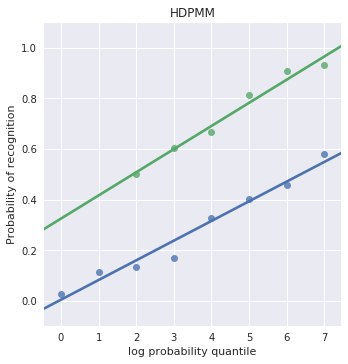

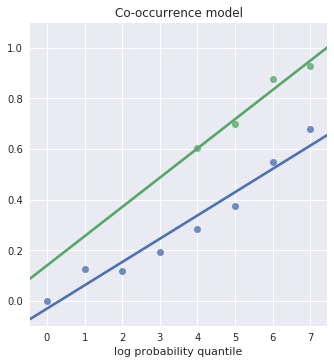

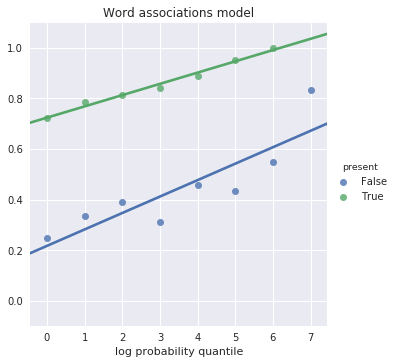

In [39]:
g = sns.lmplot(x='pp.cat', y='response', hue='expected', data=response_by_pp, size=5, ci=None, legend=False)
g.set_axis_labels("log probability quantile", "Probability of recognition");
g.set(ylim=(-0.1, 1.1))
g.set(title='HDPMM')
g.savefig('recognition_prob_pp.pdf')

g = sns.lmplot(x='cc.cat', y='response', hue='expected', data=response_by_cc, size=5, ci=None, legend=False)
g.set_axis_labels("log probability quantile", "");
g.set(ylim=(-0.1, 1.1))
g.set(title='Co-occurrence model')
g.savefig('recognition_prob_cc.pdf')

g = sns.lmplot(x='aa.cat', y='response', hue='present', data=response_by_aa, size=5, ci=None)
g.set_axis_labels("log probability quantile", "");
g.set(ylim=(-0.1, 1.1))
g.set(title='Word associations model')
g.savefig('recognition_prob_aa.pdf')

In [40]:
Df['recognition'].to_csv('_cache/recognition.csv')

In [41]:
Df['recall'].to_csv('_cache/recall.csv')